In [5]:
# Import TensorFlow and Keras modules
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import Input, Dropout, Flatten, BatchNormalization, Dense, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

In [17]:
# 🚀 Step 2: Define Dataset Paths
base_dir = "/kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

In [ ]:
# 🚀 Step 3: Load Data Using ImageDataGenerator
IMG_SIZE = (224, 224)
BATCH_SIZE = 64

In [19]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    horizontal_flip = True,
    shear_range = 0.3,
    fill_mode = 'nearest',
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    dtype=None,
    zoom_range = 0.1
)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [20]:
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

Found 34792 images belonging to 5 classes.


In [8]:
val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

Found 9940 images belonging to 5 classes.


In [21]:
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

Found 4971 images belonging to 5 classes.


In [ ]:
base_model = ResNet152V2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze all layers except the last 10
for layer in base_model.layers[:-40]:
    layer.trainable = False

# Define input
inputs = Input(shape=(224, 224, 3))

# Pass input through base model
x = base_model(inputs, training=False)

# Additional layers
x = Dropout(0.5)(x)
x = Flatten()(x)
x = BatchNormalization()(x)

x = Dense(256, kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)

x = Dense(128, kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)

x = Dense(32, kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Output layer
outputs = Dense(5, activation='softmax')(x)

# Final model
model = Model(inputs, outputs)

In [27]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet152v2 (Functional)             │ (None, 7, 7, 2048)          │      58,331,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 7, 7, 2048)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 100352)              │         401,408 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │      25,690,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 84,462,277 (322.20 MB)

 Trainable params: 41,163,141 (157.02 MB)

 Non-trainable params: 43,299,136 (165.17 MB)

In [30]:
model.compile(optimizer = Adam(0.0001),
             loss='categorical_crossentropy',
             metrics = ['accuracy'])

In [28]:
STEP_SIZE_TRAIN = train_data.n//train_data.batch_size
STEP_SIZE_VALID = val_data.n//val_data.batch_size

In [29]:
print(STEP_SIZE_TRAIN)
print(STEP_SIZE_VALID)

543
155


## Continous Training on 5/10 Epoch Batches

In [182]:
history = model.fit(
    train_data,
    steps_per_epoch=100,
    validation_data=val_data,
    epochs=5,
    verbose=1,
    validation_steps=20
)

Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 93s 876ms/step - accuracy: 0.8421 - loss: 0.3991 - val_accuracy: 0.7789 - val_loss: 0.5498
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 86s 862ms/step - accuracy: 0.8509 - loss: 0.3885 - val_accuracy: 0.7742 - val_loss: 0.5397
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 87s 872ms/step - accuracy: 0.8470 - loss: 0.3925 - val_accuracy: 0.7758 - val_loss: 0.6074
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 84s 845ms/step - accuracy: 0.8549 - loss: 0.3807 - val_accuracy: 0.7727 - val_loss: 0.5914
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 825ms/step - accuracy: 0.8523 - loss: 0.3747 - val_accuracy: 0.7641 - val_loss: 0.6130


In [183]:
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc}")

78/78 ━━━━━━━━━━━━━━━━━━━━ 20s 253ms/step - accuracy: 0.7009 - loss: 0.7940
Test Accuracy: 0.7724803686141968


In [177]:
import numpy as np

pred_probs = model.predict(test_data, verbose=1)
y_pred = np.argmax(pred_probs, axis=1)
y_true = test_data.classes


78/78 ━━━━━━━━━━━━━━━━━━━━ 19s 239ms/step


In [178]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_true, y_pred, target_names=test_data.class_indices.keys()))

              precision    recall  f1-score   support

           0       0.57      0.76      0.65      1000
           1       0.78      0.67      0.72       971
           2       0.66      0.56      0.61      1000
           3       0.97      0.94      0.96      1000
           4       0.99      0.97      0.98      1000

    accuracy                           0.78      4971
   macro avg       0.80      0.78      0.78      4971
weighted avg       0.80      0.78      0.79      4971



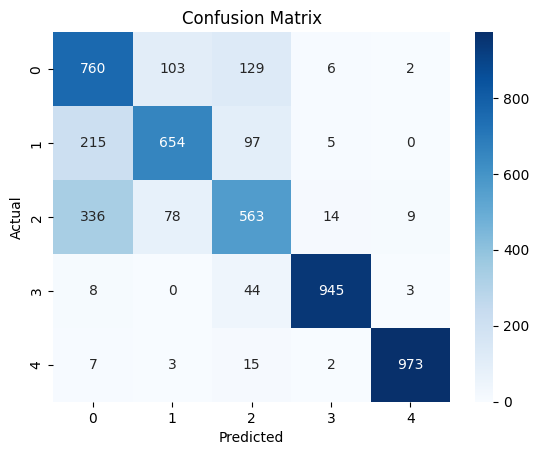

In [179]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [180]:
# Extract loss and accuracy from history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']  # For classification
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)  # Number of epochs


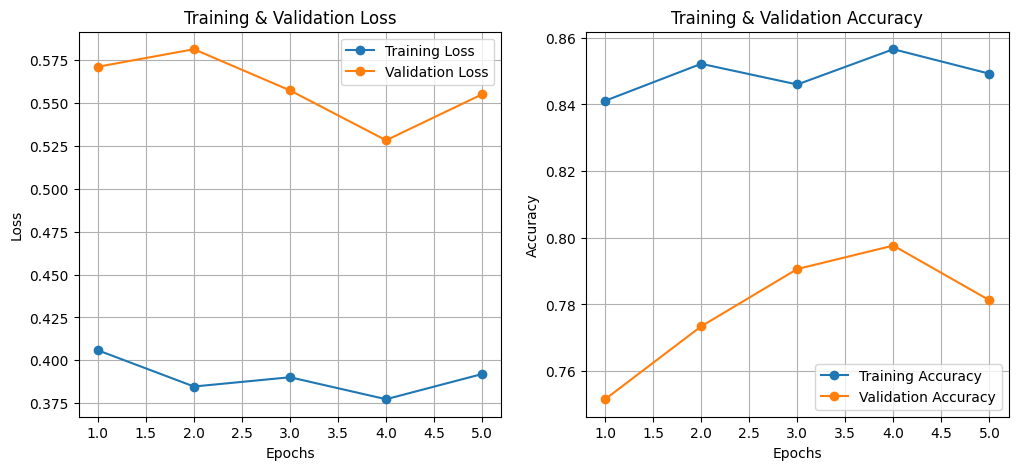

In [181]:
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Training Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.grid()

plt.show()

In [172]:
# Save the model to an .h5 file
model.save('rs_model.h5')

## Loading Saved Model From Google Drive

In [2]:
FILE_ID = "13IS0RzjePdDIvhGLYoBiywl2NjQdoKU9"
MODEL_URL = f"https://drive.google.com/uc?id={FILE_ID}"
MODEL_LOCAL_PATH = "rs_model.h5"

In [6]:
import os
import gdown
if not os.path.exists(MODEL_LOCAL_PATH):
    print("Downloading model from Google Drive...")
    gdown.download(MODEL_URL, MODEL_LOCAL_PATH, quiet=False)
    print("Download complete.")


model = tf.keras.models.load_model(MODEL_LOCAL_PATH)

In [7]:
class_labels = {
    0: "No_Dr",
    1: "Mild",
    2: "Moderate",
    3: "Severe",
    4: "Proliferative DR"
}

In [ ]:
def predict_image(model, img_path, class_labels, img_size=(224, 224)):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    predictions = model.predict(img_array)[0]
    predicted_class = np.argmax(predictions)
    confidence = predictions[predicted_class]

    # Visualization
    plt.figure(figsize=(10, 4))

    # Show image
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {class_labels[predicted_class]}\nConfidence: {confidence :.2f}%")

    plt.tight_layout()
    plt.show()

    return class_labels[predicted_class], confidence


## Testing No_DR Image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


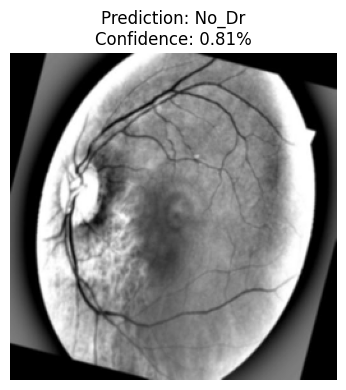

In [35]:
img_path = "/kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/test/0/10814_left._aug_16.jpeg"
predicted_label, confidence = predict_image(model, img_path, class_labels)

## Testing Mild Image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


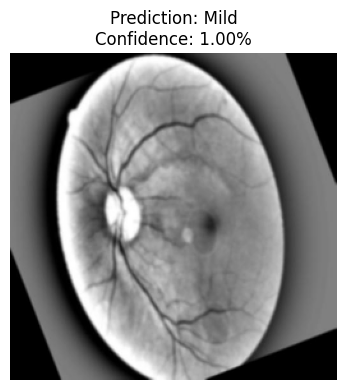

In [36]:
img_path = "/kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/test/1/10737_right._aug_22._aug_30.jpeg"
predicted_label, confidence = predict_image(model, img_path, class_labels)

## Testing Moderate Image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


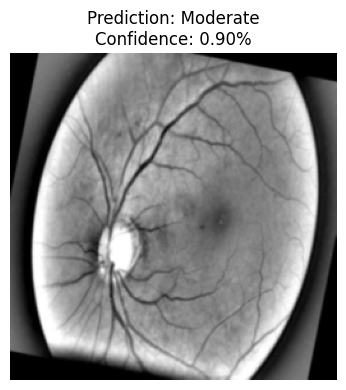

In [37]:
img_path = "/kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/test/2/11156_left._aug_27.jpeg"
predicted_label, confidence = predict_image(model, img_path, class_labels)

## Testing Severe Image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


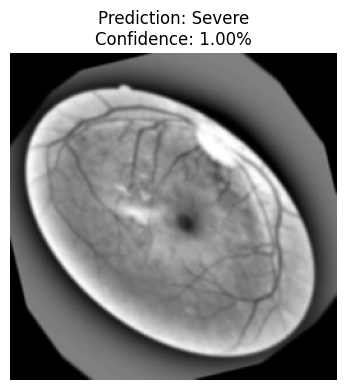

In [38]:
img_path = "/kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/test/3/11031_right._aug_5._aug_8._aug_5.jpeg"
predicted_label, confidence = predict_image(model, img_path, class_labels)

## Testing Proliferative Image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


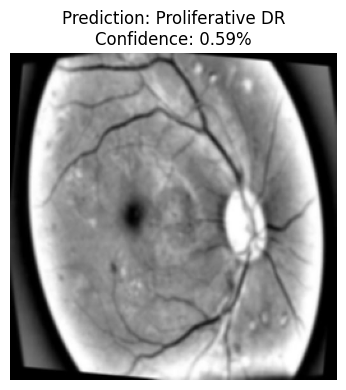

In [39]:
img_path = "/kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/test/4/1099_right._aug_22._aug_8._aug_19.jpeg"
predicted_label, confidence = predict_image(model, img_path, class_labels)